In [6]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray
import os

Grid point max total rainfall for 20251201:
168.59999
Grid point max total rainfall for 20251202:
170.65
Grid point max total rainfall for 20251203:
177.90001
Grid point max total rainfall for 20251204:
182.4
Grid point max total rainfall for 20251205:
226.5
Grid point max total rainfall for 20251206:
228.9
Grid point max total rainfall for 20251207:
256.6
Grid point max total rainfall for 20251208:
288.1
Grid point max total rainfall for 20251209:
432.09998
Grid point max total rainfall for 20251210:
523.8
Grid point max total rainfall for 20251211:
650.8999
Grid point max total rainfall for 20251212:
687.9999
Grid point max total rainfall for 20251213:
689.9999
Grid point max total rainfall for 20251214:
689.9999
Grid point max total rainfall for 20251215:
768.0999
Grid point max total rainfall for 20251216:
885.9999
Grid point max total rainfall for 20251217:
1057.4999
Grid point max total rainfall for 20251218:
1097.8999
Grid point max total rainfall for 20251219:
1172.0999
Grid po

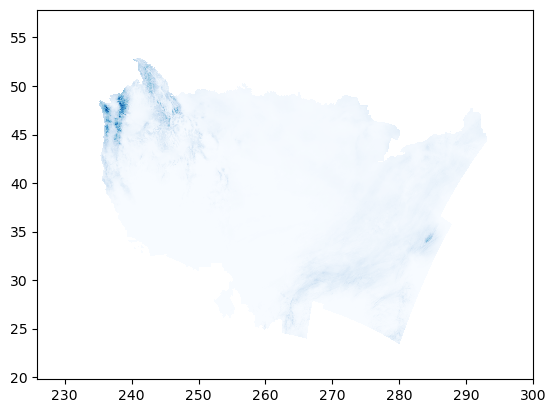

In [7]:
# Calculate rainfall accumuation: Stage IV analysis
data_dir = '/home/orca/data/in_situ/NCEP_stageIV_QPE/rt'
date_list = pd.date_range(start='2025-12-01', end='2025-12-20', freq='24h')

# Get lat/lon from one historical data file.
fn = os.path.join(
    '/home/orca/data/in_situ/NCEP_stageIV_QPE/2025/daily',
    'st4_conus.2025010112.24h.nc')

with xr.open_dataset(fn) as ds:
    lats = ds['latitude'].data
    lons = ds['longitude'].data

for tt, date in enumerate(date_list):
    date_str = date.strftime('%Y%m%d')
    file_path = os.path.join(data_dir, f'nws_precip_1day_{date_str}_conus.nc')

    with xr.open_dataset(file_path) as ds:

        x_orig = ds['x'].data
        y_orig = ds['y'].data
        precip_this_day_da = ds['observation']
        precip_this_day = ds['observation'].data[::-1,:] * 25.4  # inches --> mm
        precip_this_day[precip_this_day < -9000.0] = np.nan
        if tt == 0:
            precip = precip_this_day
        else:
            precip += precip_this_day

        # Save or process total_rainfall as needed
        print(f'Grid point max total rainfall for {date_str}:')
        print(np.nanmax(precip))

print(precip.shape, y_orig.shape, x_orig.shape)

plt.pcolormesh(lons, lats, precip, cmap='Blues')

In [8]:
# Create xarray dataset with precip, lon, and lat
precip_ds = xr.Dataset(
    data_vars={
        'precip': (['y', 'x'], precip)
    },
    coords={
        'y': (['y',], y_orig[::-1]),
        'x': (['x',], x_orig)
    }
)

precip_ds['precip'].attrs["units"] = "mm"
precip_ds['precip'].attrs["long_name"] = "Accumulated rainfall"
precip_ds['precip'].rio.write_nodata(0, inplace=True)

# Export to GeoTIFF
# Manually encode native HRAP projection.
hrap_crs = (
    "+proj=stere "
    "+lat_0=90 "
    "+lat_ts=60 "
    "+lon_0=-105 "
    "+a=6371200 "
    "+b=6371200 "
    "+units=m "
    "+no_defs"
)

precip_ds = precip_ds.rio.set_spatial_dims(x_dim="x", y_dim="y")
precip_ds = precip_ds.rio.write_crs(hrap_crs)

print(precip_ds)
print(precip_ds.rio.crs)
print(precip_ds.rio.transform())

precip_ds.rio.to_raster(
    "rainfall_4km.tif",
    driver="COG",
    compress="DEFLATE",
    dtype="float32",
    nodata=-9999
)


<xarray.Dataset> Size: 4MB
Dimensions:      (y: 881, x: 1121)
Coordinates:
  * y            (y) float64 7kB -7.617e+06 -7.612e+06 ... -3.431e+06 -3.426e+06
  * x            (x) float64 9kB -1.903e+06 -1.898e+06 ... 3.427e+06 3.431e+06
    spatial_ref  int64 8B 0
Data variables:
    precip       (y, x) float32 4MB nan nan nan nan nan ... nan nan nan nan nan
PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["unknown",6371200,0]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",60],PARAMETER["central_meridian",-105],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",SOUTH],AXIS["Northing",SOUTH]]
| 4762.50, 0.00,-1904912.11|
| 0.00, 4762.50,-7619546.20|
| 0.00, 0.00, 1.00|


In [16]:
# Stage on AWS S3
import boto3
s3 = boto3.resource('s3')
bucket='gaia-hazlab-map-data'
s3.Bucket(bucket).upload_file("./rainfall_4km.tif", "rainfall_4km.tif")